# Analyse des disciplines académiques

Question : quelles sont les disciplines académiques principales des intellectuels contemporains ?

## Importation des librairies

In [14]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [15]:
import pprint
import csv
import ast
import re

from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

In [16]:
from ipywidgets import (
    interact, IntSlider, Checkbox,
    interactive, SelectMultiple)

In [17]:
import sparql_functions as spqf

In [18]:
reload(spqf)

<module 'sparql_functions' from 'C:\\jupyter_notebooks\\JS_intellectuels\\sparql_functions.py'>

## Préparation des données

In [19]:
db = 'data/intellectuels.db'

In [20]:
academicDiscipline = """
WITH tw0 AS(
SELECT DISTINCT uri_entity ,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END academicDiscipline
FROM
	property
WHERE
	property IN ('http://dbpedia.org/ontology/academicDiscipline')
), tw1 AS (
SELECT GROUP_CONCAT(value) birth_dates, uri_entity, count(*) as eff
FROM property p
WHERE p.property LIKE '%birthD%' OR p.property LIKE '%birthY%'
GROUP BY uri_entity)
SELECT tw1.uri_entity, tw1.birth_dates, academicDiscipline
FROM tw1, tw0
WHERE tw1.uri_entity = tw0.uri_entity;
"""

In [21]:
# Connnexion à la base de données
cn = sql.connect(db)
c = cn.cursor()

### Exécuter la requête sur la base de donées SQLite pour récupérer les valeurs que contient la ligne
c.execute(academicDiscipline)
result_q = []
result_q = c.fetchall()

# Fermer la connexion et afficher les cinq premiers résultats
cn.close()
print(len(result_q))
result_q[:10]

10786


[('http://dbpedia.org/resource/A._Bernard_Ackerman',
  '1936-11-22,1936,1936-11-22',
  'Dermatology'),
 ('http://dbpedia.org/resource/A._Bernard_Ackerman',
  '1936-11-22,1936,1936-11-22',
  'Pathology'),
 ('http://dbpedia.org/resource/A._Carl_Helmholz',
  '1915-05-24,1915,1915-05-24',
  'Nuclear_physics'),
 ('http://dbpedia.org/resource/A._E._Douglass',
  '1867-07-05,1867,1867-07-05',
  'Astronomy'),
 ('http://dbpedia.org/resource/A._E._Douglass',
  '1867-07-05,1867,1867-07-05',
  'Dendrochronology'),
 ('http://dbpedia.org/resource/A._E._Trueman',
  '1894-04-26,1894,1894-04-26',
  'Geology'),
 ('http://dbpedia.org/resource/A._F._K._Organski',
  '1923-05-12,1923,1923-05-12',
  'Political_Science'),
 ('http://dbpedia.org/resource/A._G._Leonard',
  '1865-03-15,1865,1865-03-15',
  'Geology'),
 ('http://dbpedia.org/resource/A._I._Sabra',
  '1924-07-08,1924,1924-07-08',
  'History_of_science'),
 ('http://dbpedia.org/resource/A._J._Arkell',
  '1898-07-29,1898,1898-07-29',
  'Archaeology')]

In [22]:
# Crée un DataFrame avec les résultats de la requête concernant l'année de naissance et la nationalité
df_result = pd.DataFrame(result_q)
df_result.columns =['uri_entity','dates', 'academicDiscipline']
# Affiche les cinq premiers résultats
df_result [:5]

,uri_entity,dates,academicDiscipline
0,http://dbpedia.org/resource/A._Bernard_Ackerman,"1936-11-22,1936,1936-11-22",Dermatology
1,http://dbpedia.org/resource/A._Bernard_Ackerman,"1936-11-22,1936,1936-11-22",Pathology
2,http://dbpedia.org/resource/A._Carl_Helmholz,"1915-05-24,1915,1915-05-24",Nuclear_physics
3,http://dbpedia.org/resource/A._E._Douglass,"1867-07-05,1867,1867-07-05",Astronomy
4,http://dbpedia.org/resource/A._E._Douglass,"1867-07-05,1867,1867-07-05",Dendrochronology


### Nettoyer les années de naissance

In [23]:
# Extraire les années
listeDateNaiss = []
annee = re.compile(r'\d{4}')

for l in result_q:
    listeDateNaiss.append(annee.findall(l[0])) 
    
# Vérifier que la longueur de la liste corresponde aux données de la base de données
len(listeDateNaiss)

10786

In [24]:
# Extraire l'année de chaque ligne.
df_result['anneeNaiss'] = df_result['dates'].apply(lambda row: annee.findall(row)[0] if annee.findall(row) else None)  
# Affiche les cinq premiers résultats
df_result[:5]

,uri_entity,dates,academicDiscipline,anneeNaiss
0,http://dbpedia.org/resource/A._Bernard_Ackerman,"1936-11-22,1936,1936-11-22",Dermatology,1936
1,http://dbpedia.org/resource/A._Bernard_Ackerman,"1936-11-22,1936,1936-11-22",Pathology,1936
2,http://dbpedia.org/resource/A._Carl_Helmholz,"1915-05-24,1915,1915-05-24",Nuclear_physics,1915
3,http://dbpedia.org/resource/A._E._Douglass,"1867-07-05,1867,1867-07-05",Astronomy,1867
4,http://dbpedia.org/resource/A._E._Douglass,"1867-07-05,1867,1867-07-05",Dendrochronology,1867


In [25]:
# Crée un tableau montrant les entités, leurs écoles philosophiques et leur année de naissance
academicDiscipline = df_result[['uri_entity', 'academicDiscipline', 'anneeNaiss']]
print(len(academicDiscipline))
academicDiscipline

10786


,uri_entity,academicDiscipline,anneeNaiss
0,http://dbpedia.org/resource/A._Bernard_Ackerman,Dermatology,1936
1,http://dbpedia.org/resource/A._Bernard_Ackerman,Pathology,1936
2,http://dbpedia.org/resource/A._Carl_Helmholz,Nuclear_physics,1915
3,http://dbpedia.org/resource/A._E._Douglass,Astronomy,1867
4,http://dbpedia.org/resource/A._E._Douglass,Dendrochronology,1867
...,...,...,...
10781,http://dbpedia.org/resource/Øystein_Sørensen,Norway_during_World_War_II,1954
10782,http://dbpedia.org/resource/Øystein_Sørensen,Totalitarianism,1954
10783,http://dbpedia.org/resource/İlber_Ortaylı,History,1947
10784,http://dbpedia.org/resource/Şükrü_Halûk_Akalın,Turkish_language,1956


In [26]:
# Crée un tableau montrant les entités, leurs intérêts et leur année de naissance, en ne retenant que les personnes nées après 1770
academicDiscipline_tri = df_result[['uri_entity', 'academicDiscipline', 'anneeNaiss']]
academicDiscipline_tri = academicDiscipline_tri[academicDiscipline_tri['anneeNaiss'] > '1880']
print(len(academicDiscipline_tri))
academicDiscipline_tri

8399


,uri_entity,academicDiscipline,anneeNaiss
0,http://dbpedia.org/resource/A._Bernard_Ackerman,Dermatology,1936
1,http://dbpedia.org/resource/A._Bernard_Ackerman,Pathology,1936
2,http://dbpedia.org/resource/A._Carl_Helmholz,Nuclear_physics,1915
5,http://dbpedia.org/resource/A._E._Trueman,Geology,1894
6,http://dbpedia.org/resource/A._F._K._Organski,Political_Science,1923
...,...,...,...
10781,http://dbpedia.org/resource/Øystein_Sørensen,Norway_during_World_War_II,1954
10782,http://dbpedia.org/resource/Øystein_Sørensen,Totalitarianism,1954
10783,http://dbpedia.org/resource/İlber_Ortaylı,History,1947
10784,http://dbpedia.org/resource/Şükrü_Halûk_Akalın,Turkish_language,1956


### Analyse des academicDiscipline

In [27]:
# Combien de "academicDiscipline" différentes et leur répartition
groupacademicDiscipline = academicDiscipline.groupby('academicDiscipline').size()
groupacademicDiscipline.sort_values(ascending=False)

academicDiscipline
Mathematics                907
Physics                    513
Chemistry                  236
Astronomy                  211
Computer_science           182
                          ... 
Middle_Ages                  1
Middle_East_History          1
Middle_Eastern_Studies       1
Middle_Eastern_studies       1
19th_century_philosophy      1
Length: 2508, dtype: int64

In [28]:
# Transformer l'objet Series en DataFrame et ajouter le nom de la colonne 'effectif'
df_groupacademicDiscipline = groupacademicDiscipline.to_frame()
df_groupacademicDiscipline.columns = ['effectif']
df_groupacademicDiscipline

,effectif
academicDiscipline,
19th_century_philosophy,1
3D_printing,1
AI,1
AIDS,2
AI_planning,1
...,...
Zoologist,1
Zoology,102
http://mitpress.mit.edu/books/reasoning-about-knowledge,1


## Filtrage des occupation

In [29]:
# Transformer l'objet Series en DataFrame et ajouter le nom de la colonne 'effectif' en ne gardant que les effectifs > 69
df_groupacademicDiscipline = groupacademicDiscipline.to_frame()
df_groupacademicDiscipline.columns = ['effectif']
df_groupacademicDiscipline = df_groupacademicDiscipline[df_groupacademicDiscipline['effectif'] > 69]
df_groupacademicDiscipline

,effectif
academicDiscipline,
Anthropology,99
Archaeology,105
Astronomy,211
Astrophysics,70
Biochemistry,129
Biology,92
Botany,163
Chemistry,236
Computer_Science,75


In [30]:
df_groupacademicDiscipline.sort_values(by='effectif', ascending=False)

,effectif
academicDiscipline,
Mathematics,907
Physics,513
Chemistry,236
Astronomy,211
Computer_science,182
Botany,163
Psychology,149
Geology,138
Biochemistry,129


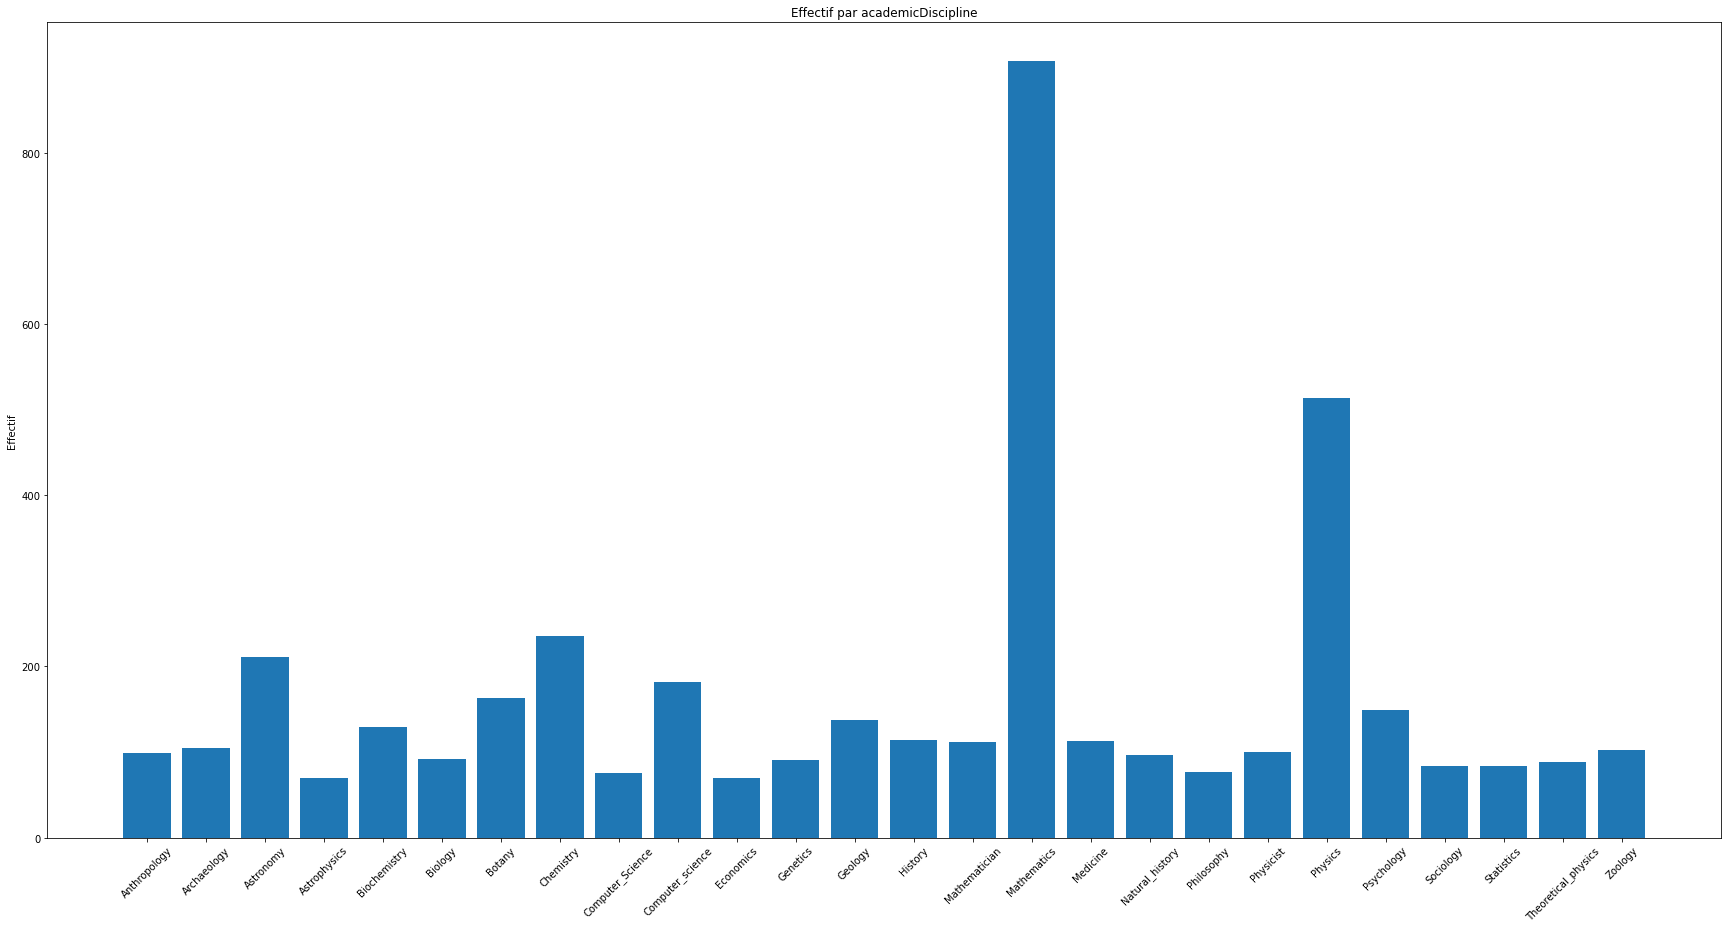

In [42]:
# Création d'un diagramme en barres montrant l'effectif d'individus par nationalité

objects = [l for l in df_groupacademicDiscipline.index]
eff = [l for l in df_groupacademicDiscipline['effectif']]

p1 = plt.bar(objects, eff)

plt.ylabel('Effectif')
plt.title('Effectif par academicDiscipline')
plt.gcf().set_size_inches(30, 15)

plt.xticks(rotation=45)
plt.show()